<a href="https://colab.research.google.com/github/Bhar8at/DLR/blob/main/1Darray_Automap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import zipfile, os
from google.colab import files

# Upload Sinograms
print("Upload zipped sinogram folder : ")
sino_zip = files.upload()
sino_zip_name = list(sino_zip.keys())[0]

# Upload CTs
print("Upload zipped CT Image folder : ")
ct_zip = files.upload()
ct_zip_name = list(ct_zip.keys())[0]

# Unzip both
os.makedirs("data/sinos", exist_ok=True)
os.makedirs("data/cts", exist_ok=True)

with zipfile.ZipFile(sino_zip_name, 'r') as zip_ref:
  zip_ref.extractall("data/sinos")

with zipfile.ZipFile(ct_zip_name, 'r') as zip_ref:
  zip_ref.extractall("data/cts")

Upload zipped sinogram folder : 


Saving sino_finallll.zip to sino_finallll.zip
Upload zipped CT Image folder : 


Saving CT_64x64_RESIZED.zip to CT_64x64_RESIZED.zip


In [2]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os

input_dir = "data/sinos"
output_dir = "data/cts"

input_files = sorted([f for f in os.listdir(input_dir) if f.endswith(('.jpg', '.png'))])
output_files = sorted([f for f in os.listdir(output_dir) if f.endswith(('.jpg', '.png'))])

x_data = []
y_data = []

for in_file, out_file in zip(input_files, output_files):
    # Sinogram: Load and flatten
    sinogram = load_img(os.path.join(input_dir, in_file), color_mode='grayscale', target_size=(180, 64))
    sinogram_arr = img_to_array(sinogram).squeeze() / 255.0
    x_data.append(sinogram_arr.flatten())  # shape = (180*64,) = (11520,)

    # CT image: Load as 64x64 image
    ct = load_img(os.path.join(output_dir, out_file), color_mode='grayscale', target_size=(64, 64))
    ct_arr = img_to_array(ct).squeeze() / 255.0
    y_data.append(ct_arr[..., np.newaxis])  # shape = (64, 64, 1)

x_data = np.array(x_data, dtype=np.float32)
y_data = np.array(y_data, dtype=np.float32)

print("x_data shape (flattened sinograms):", x_data.shape)  # (N, 11520)
print("y_data shape (CT images):", y_data.shape)            # (N, 64, 64, 1)


x_data shape (flattened sinograms): (125, 11520)
y_data shape (CT images): (125, 64, 64, 1)


In [3]:
x_train = x_data[:100]
x_test = x_data[100:]
y_train = y_data[:100]
y_test = y_data[100:]

print("x_train:", x_train.shape)
print("y_train:", y_train.shape)


x_train: (100, 11520)
y_train: (100, 64, 64, 1)


In [4]:
from tensorflow.keras import models
from tensorflow.keras.layers import Input, Dense, Reshape, Conv2D, Dropout, Conv2DTranspose

def build_automap_1d(input_dim=11520):
    inputs = Input(shape=(input_dim,))

    x = Dense(4096, activation='tanh')(inputs)
    x = Dense(2048, activation='tanh')(x)
    x = Dense(64*64, activation='tanh')(x)  # Final dense layer maps to CT image

    x = Reshape((64, 64, 1))(x)

    # Optional post-processing: small Conv stack
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Conv2D(16, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(1, (3, 3), padding='same', activation='sigmoid')(x)

    return models.Model(inputs, x)


In [5]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

model = build_automap_1d(input_dim=180*64)

model.compile(
    optimizer=Adam(1e-4),
    loss='mse',
    metrics=[MeanAbsoluteError()]
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 11520)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    47,190,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2048)           │     8,390,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4096)           │     8,392,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 1)      │           145 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,978,465 (244.06 MB)

 Trainable params: 63,978,465 (244.06 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=4,
    epochs=20,
    verbose=1
)


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - loss: 0.0445 - mean_absolute_error: 0.1344 - val_loss: 0.0402 - val_mean_absolute_error: 0.1276
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - loss: 0.0434 - mean_absolute_error: 0.1305 - val_loss: 0.0401 - val_mean_absolute_error: 0.1222
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 0.0426 - mean_absolute_error: 0.1266 - val_loss: 0.0376 - val_mean_absolute_error: 0.1204
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - loss: 0.0413 - mean_absolute_error: 0.1252 - val_loss: 0.0377 - val_mean_absolute_error: 0.1215
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 0.0386 - mean_absolute_error: 0.1200 - val_loss: 0.0367 - val_mean_absolute_error: 0.1194
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - loss: 0.0383 - mean_absolute_error: 0.1191 - val_loss: 0.0348 - val_mean_absolute_error: 0.1134
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 0.0364 - mean_absolute_error: 0.1147 - val_loss: 0.034

In [8]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 11520)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    47,190,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2048)           │     8,390,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4096)           │     8,392,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 1)      │           145 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 191,935,397 (732.18 MB)

 Trainable params: 63,978,465 (244.06 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 127,956,932 (488.12 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


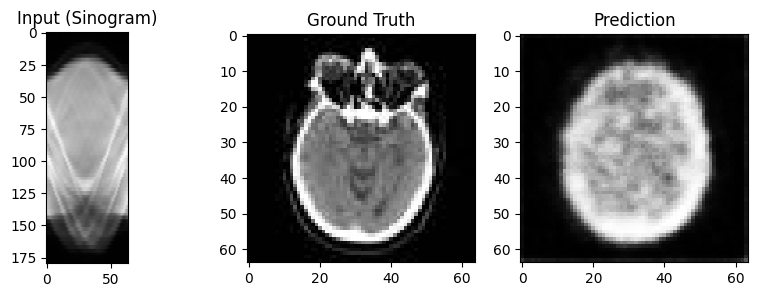

In [9]:
import matplotlib.pyplot as plt

i = 5
pred = model.predict(x_test[i:i+1])[0]

plt.figure(figsize=(10, 3))
plt.subplot(1, 3, 1)
plt.imshow(x_test[i].reshape(180, 64), cmap='gray')
plt.title("Input (Sinogram)")

plt.subplot(1, 3, 2)
plt.imshow(y_test[i].squeeze(), cmap='gray')
plt.title("Ground Truth")

plt.subplot(1, 3, 3)
plt.imshow(pred.squeeze(), cmap='gray')
plt.title("Prediction")

plt.show()


In [10]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

psnr_list = []
ssim_list = []

for i in range(len(x_test)):
    pred = model.predict(x_test[i:i+1])[0].squeeze()
    gt = y_test[i].squeeze()

    psnr_val = psnr(gt, pred, data_range=1.0)
    ssim_val = ssim(gt, pred, data_range=1.0)

    psnr_list.append(psnr_val)
    ssim_list.append(ssim_val)

print(f"📈 Average PSNR on test set: {np.mean(psnr_list):.2f} dB")
print(f"📈 Average SSIM on test set: {np.mean(ssim_list):.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
📈 Average PSNR on test set: 15.19 dB
📈 Average